In [1]:
import os
import numpy as np
from tqdm import tqdm
from trunk_sim.data import TrunkData
from trunk_sim.policy import HarmonicPolicy, RandomWalkPolicy, steady_state_input
from trunk_sim.rollout import rollout
from opt_ssm.plotting import plot_trajectories, plot_trunk_results
from opt_ssm.ssm import DelaySSM, OptSSM
from opt_ssm.systems import Trunk
from opt_ssm.models import SSMR, get_residual_labels
from opt_ssm.residual import ResidualBr, PolyBr
from opt_ssm.mpc import generate_ref_trajectory, run_mpc
from opt_ssm.misc import HyperRectangle
from opt_ssm.gusto import GuSTOConfig
import jax
import jax.numpy as jnp

import pickle

INFO:2025-05-12 17:19:26,473:jax._src.xla_bridge:867: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO   2025-05-12 17:19:26 xla_bridge Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING 2025-05-12 17:19:26 xla_bridge An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/patrick/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Instantiate Trunk simulator
trunk = Trunk()

COLLECT = True
OPTIMIZE = True

In [ ]:
# Instantiate Trunk Data class
trunk_aut_data = TrunkData(
    trunk.num_links_per_segment,
    trunk.num_segments,
    states="pos_vel",
    segments="all",
)

# Collect autonomous Trunk data
def collect_data(system: Trunk,
                 data: TrunkData,
                 num_rollouts: int = 20,
                 policy: str = "none",
                 name: str = "autonomous_data"
                 ):
    if not os.path.exists(system.data_folder):
        os.makedirs(system.data_folder)

    if system.render_video and not os.path.exists(
        os.path.join(system.data_folder, "videos")
    ):
        os.makedirs(os.path.join(system.data_folder, "videos"))

    if policy == "harmonic":
        policy = HarmonicPolicy(
            frequency_range=[0.5, 5],
            amplitude_range=[0.5, 2.5],
            phase_range=[0, 2 * np.pi],
            num_segments=trunk.num_segments
        )
    elif policy == "random_walk":
        policy = RandomWalkPolicy()
    elif policy == "none":
        policy = None
    else:
        raise ValueError(f"Invalid policy: {policy}")
    
    for rollout_idx in tqdm(range(num_rollouts)):

        if system.init_steady_state:
            angle = np.random.uniform(0,2*np.pi)
            sign = np.random.choice([-1,1])
            system.simulator.set_initial_steady_state(
                steady_state_input(system.simulator.num_segments, amplitude=np.random.uniform(0.0, 15.0), angle=angle),
                kick=steady_state_input(system.simulator.num_segments, amplitude=np.random.uniform(5.0, 12.5), angle=angle + np.pi/2 * sign),
                kick_duration=0.5,
            )

        rollout(
            simulator=system.simulator,
            policy=policy,
            data=data,
            duration=system.duration,
            render_video=system.render_video,
            video_filename=os.path.join(
                system.data_folder, "videos", f"rollout_{rollout_idx}.mp4"
            ),
            stop_at_convergence=system.stop_at_convergence,
            traj_ID = rollout_idx
        )

    data.save_to_csv(os.path.join(system.data_folder, name + ".csv"))


if COLLECT:
    collect_data(trunk, trunk_aut_data)
else:
    trunk_aut_data.load_from_csv(os.path.join(trunk.data_folder, "autonomous_data.csv"))
print("Number of autonomous data points: ", len(trunk_aut_data))

# Extract arrays
tss, aut_trajs, _, _ = trunk_aut_data.convert_to_arrays()

# Visualize tip trajectories
plot_trajectories(aut_trajs[:, 12:15], tss[0])

IndentationError: unindent does not match any outer indentation level (<string>, line 7)

# Find optimal (oblique) linear projection and compare with orthogonal projection

In [ ]:
N_aut_train = 10
tip_positions = jnp.array(aut_trajs[:N_aut_train, 12:15])
tip_velocities = jnp.array(aut_trajs[:N_aut_train, 15:18])
aut_trajs_obs = tip_positions
ts = tss[0]

if OPTIMIZE:
    # Center the Z coordinate
    aut_trajs_obs = aut_trajs_obs.at[:, 2].set(aut_trajs_obs[:, 2] - jnp.mean(aut_trajs_obs[:, 2, -1]))

    ssm_opt = OptSSM(aut_trajs_obs=aut_trajs_obs,
                    t_split=3.5,
                    SSMDim=5,
                    SSMOrder=2,
                    ROMOrder=2,
                    N_delay=3,
                    ts=ts,
                    verbose=True)

    ssm_orth = DelaySSM(aut_trajs_obs=aut_trajs_obs,
                        SSMDim=5,
                        SSMOrder=2,
                        ROMOrder=2,
                        N_delay=3,
                        N_obs_delay=3,
                        orthogonalize=True,
                        ts=ts)

    with open("ssm_opt.pkl", "wb") as f:
        pickle.dump(ssm_opt, f)

    with open("ssm_orth.pkl", "wb") as f:
        pickle.dump(ssm_orth, f)

In [ ]:
with open("ssm_opt.pkl", "rb") as f:
    ssm_opt = pickle.load(f)
with open("ssm_orth.pkl", "rb") as f:
    ssm_orth = pickle.load(f)

# Simulate controlled system
Two control inputs per joint that decompose into torque and force along the pendulum.

Number of controlled data points:  30000


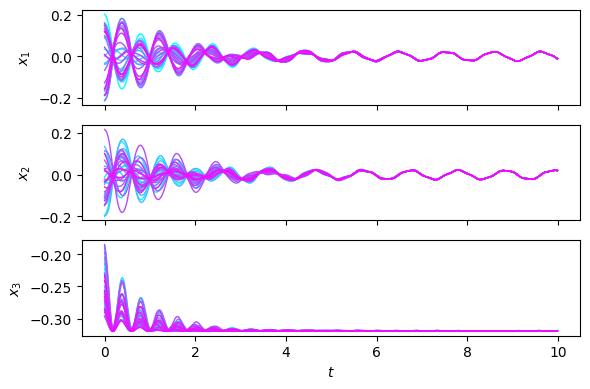

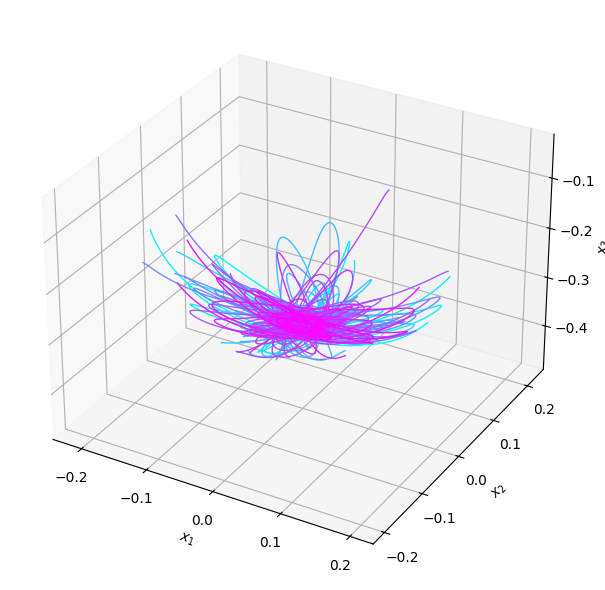

In [ ]:
# Instantiate Trunk Data class
trunk_ctrl_data = TrunkData(
    trunk.num_links_per_segment,
    trunk.num_segments,
    states="pos_vel",
    segments="all",
)

if COLLECT:
    collect_data(trunk, trunk_ctrl_data, num_rollouts=30, policy="harmonic", name="controlled_data")
else:
    trunk_ctrl_data.load_from_csv(os.path.join(trunk.data_folder, "controlled_data.csv"))
print("Number of controlled data points: ", len(trunk_ctrl_data))

# Extract arrays
tss, ctrl_trajs, control_inputs, _ = trunk_ctrl_data.convert_to_arrays()

# Visualize tip trajectories
plot_trajectories(ctrl_trajs[:, 12:15], tss[0])

In [ ]:
N_ctrl_train = 20
ctrl_tip_positions = jnp.array(ctrl_trajs[:N_ctrl_train, 12:15])
ctrl_tip_velocities = jnp.array(ctrl_trajs[:N_ctrl_train, 15:18])
ctrl_trajs_obs = ctrl_tip_positions
us = control_inputs[:N_ctrl_train]
ts = tss[0]

# Center the Z coordinate
ctrl_trajs_obs = ctrl_trajs_obs.at[:, 2].set(ctrl_trajs_obs[:, 2] - jnp.mean(ctrl_trajs_obs[:, 2, -1]))

# Fit B_r for both models

In [ ]:
# Obtain labels used to fit B_r
xs_flat, us_flat, delta_x_dots_flat = get_residual_labels(ssm_orth, ctrl_trajs_obs, ts, us=us)

# Fit the residual model
poly_B_r = PolyBr(5, 6, 0, 0.0)
poly_B_r.fit(xs_flat, us_flat, delta_x_dots_flat)
residual_B_r = ResidualBr(poly_B_r)
obs_perf_matrix = jnp.zeros((3, (ssm_orth.N_obs_delay + 1) * 3))
obs_perf_matrix = obs_perf_matrix.at[:, 0:3].set(jnp.eye(3))
ssmr_orth = SSMR(ssm_orth, residual_B_r, obs_perf_matrix)

# Likewise for the optimal projection model
xs_flat, us_flat, delta_x_dots_flat = get_residual_labels(ssm_opt, ctrl_trajs_obs, ts, us=us)
poly_B_r = PolyBr(5, 6, 0, 0.0)
poly_B_r.fit(xs_flat, us_flat, delta_x_dots_flat)
residual_B_r = ResidualBr(poly_B_r)
ssmr_opt = SSMR(ssm_opt, residual_B_r, obs_perf_matrix)

with open("ssmr_opt.pkl", "wb") as f:
    pickle.dump(ssmr_opt, f)

with open("ssmr_orth.pkl", "wb") as f:
    pickle.dump(ssmr_orth, f)

In [ ]:
with open("ssmr_opt.pkl", "rb") as f:
    ssmr_opt = pickle.load(f)
with open("ssmr_orth.pkl", "rb") as f:
    ssmr_orth = pickle.load(f)

# Run MPC

In [ ]:
# Generate reference trajectory
dt = 0.01
T_f = 2.5
t_mpc = jnp.arange(0, T_f+dt, dt)
traj_type = 'figure_eight'
if traj_type == 'figure_eight':
    z_ref = generate_ref_trajectory(t_mpc, type=traj_type, T=T_f, A=0.125, dim=3)
elif traj_type == 'circle':
    z_ref = generate_ref_trajectory(t_mpc, type=traj_type, T=T_f, A=0.2, dim=2)

In [ ]:
# Set MPC parameters
u_scale = 0.1
ρ, dρ = 1e-7, 1e-3
R = ρ * u_scale**2 * jnp.eye(ssmr_orth.n_u)
R_du = dρ * u_scale**2 * jnp.eye(ssmr_orth.n_u)
Q = jnp.eye(ssmr_orth.n_z)
Q = Q.at[2, 2].set(0.0)
gusto_config_orth = GuSTOConfig(
    Qz=Q,
    Qzf=Q,
    R=R,
    R_du=R_du,
    x_char=jnp.ones(ssmr_orth.n_x),
    f_char=jnp.ones(ssmr_orth.n_x),
    N=8,
    dt=dt
)

gusto_config_opt = GuSTOConfig(
    Qz=Q,
    Qzf=5*Q if traj_type == 'figure_eight' else Q,
    R=10*R,
    R_du=R_du,
    x_char=jnp.ones(ssmr_opt.n_x),
    f_char=jnp.ones(ssmr_opt.n_x),
    N=8,
    dt=dt
)

In [ ]:
# Solve MPC problem
U = HyperRectangle([20.0] * 6, [-20.0] * 6)  # set bounds on control inputs if desired (not tight here)
x_mpc_orth, z_mpc_orth, u_mpc_orth, z_true_orth = run_mpc(
    trunk,
    ssmr_orth,
    gusto_config_orth,
    z_ref,
    U=U,
    dU=None,
    N_exec=2)
x_mpc_opt, z_mpc_opt, u_mpc_opt, z_true_opt = run_mpc(
    trunk,
    ssmr_opt,
    gusto_config_opt,
    z_ref,
    U=U,
    dU=None,
    N_exec=2)

First solve may take a while due to factorization and caching.
Solved in 1 iterations/28.627 seconds, with 0.048 s from LOCP solve


  0%|          | 0/242 [00:00<?, ?it/s]/home/patrick/miniconda3/envs/opt-ssm3/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 0 of problem cannot be solved, see solver status for more information


  3%|▎         | 7/242 [00:01<00:38,  6.06it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 2 iterations/0.067 seconds, with 0.037 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.006 s from LOCP solve
Solved in 1 iterations/0.026 seconds, with 0.014 s from LOCP solve


  5%|▍         | 11/242 [00:01<00:23,  9.89it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 2 iterations/0.039 seconds, with 0.015 s from LOCP solve
Solving with warm-start failed, so turning off


  7%|▋         | 18/242 [00:02<00:15, 14.45it/s]

Solver still failed, returning inf
Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 2 iterations/0.101 seconds, with 0.077 s from LOCP solve
Solved in 1 iterations/0.028 seconds, with 0.014 s from LOCP solve


 10%|▉         | 23/242 [00:02<00:10, 19.93it/s]

Solved in 1 iterations/0.028 seconds, with 0.015 s from LOCP solve
Solved in 1 iterations/0.024 seconds, with 0.013 s from LOCP solve
Solved in 1 iterations/0.022 seconds, with 0.010 s from LOCP solve
Solved in 1 iterations/0.031 seconds, with 0.017 s from LOCP solve


 14%|█▍        | 35/242 [00:02<00:07, 26.93it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.033 seconds, with 0.021 s from LOCP solve
Solved in 1 iterations/0.023 seconds, with 0.012 s from LOCP solve
Iteration 0 of problem cannot be solved, see solver status for more information


 16%|█▌        | 39/242 [00:02<00:07, 29.00it/s]

Solved in 2 iterations/0.054 seconds, with 0.023 s from LOCP solve
Solved in 1 iterations/0.026 seconds, with 0.013 s from LOCP solve
Solved in 1 iterations/0.089 seconds, with 0.078 s from LOCP solve


 19%|█▉        | 47/242 [00:03<00:07, 27.00it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.050 seconds, with 0.037 s from LOCP solve
Solved in 1 iterations/0.032 seconds, with 0.020 s from LOCP solve
Solved in 1 iterations/0.031 seconds, with 0.018 s from LOCP solve
Solved in 1 iterations/0.026 seconds, with 0.014 s from LOCP solve


 24%|██▍       | 59/242 [00:03<00:05, 34.02it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.027 seconds, with 0.016 s from LOCP solve
Solved in 1 iterations/0.024 seconds, with 0.011 s from LOCP solve
Solved in 1 iterations/0.030 seconds, with 0.018 s from LOCP solve


 26%|██▌       | 63/242 [00:03<00:06, 27.98it/s]

Solved in 1 iterations/0.096 seconds, with 0.081 s from LOCP solve
Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.031 seconds, with 0.019 s from LOCP solve
Solved in 1 iterations/0.029 seconds, with 0.017 s from LOCP solve


 30%|███       | 73/242 [00:04<00:05, 29.71it/s]

Solved in 1 iterations/0.023 seconds, with 0.012 s from LOCP solve
Solved in 1 iterations/0.052 seconds, with 0.010 s from LOCP solve
Solved in 1 iterations/0.052 seconds, with 0.035 s from LOCP solve


 32%|███▏      | 77/242 [00:04<00:05, 29.66it/s]

Solved in 1 iterations/0.042 seconds, with 0.026 s from LOCP solve
Solved in 1 iterations/0.068 seconds, with 0.053 s from LOCP solve
Solved in 1 iterations/0.033 seconds, with 0.021 s from LOCP solve
Solved in 1 iterations/0.027 seconds, with 0.015 s from LOCP solve


 36%|███▌      | 87/242 [00:04<00:04, 32.66it/s]

Solved in 1 iterations/0.020 seconds, with 0.010 s from LOCP solve
Solved in 1 iterations/0.073 seconds, with 0.062 s from LOCP solve
Solved in 1 iterations/0.033 seconds, with 0.016 s from LOCP solve
Solved in 1 iterations/0.023 seconds, with 0.007 s from LOCP solve


 40%|████      | 97/242 [00:04<00:03, 36.40it/s]

Solved in 1 iterations/0.031 seconds, with 0.018 s from LOCP solve
Solved in 1 iterations/0.034 seconds, with 0.022 s from LOCP solve
Solved in 1 iterations/0.046 seconds, with 0.033 s from LOCP solve
Solved in 1 iterations/0.036 seconds, with 0.026 s from LOCP solve


 44%|████▍     | 107/242 [00:04<00:03, 35.85it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.029 seconds, with 0.016 s from LOCP solve
Solved in 1 iterations/0.033 seconds, with 0.020 s from LOCP solve
Solved in 1 iterations/0.025 seconds, with 0.015 s from LOCP solve
Solved in 1 iterations/0.036 seconds, with 0.022 s from LOCP solve


 48%|████▊     | 117/242 [00:05<00:03, 37.67it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.019 seconds, with 0.005 s from LOCP solve
Solved in 1 iterations/0.019 seconds, with 0.006 s from LOCP solve
Solved in 1 iterations/0.018 seconds, with 0.006 s from LOCP solve
Solved in 1 iterations/0.025 seconds, with 0.006 s from LOCP solve
Solved in 1 iterations/0.022 seconds, with 0.011 s from LOCP solve


 52%|█████▏    | 127/242 [00:05<00:02, 40.19it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.020 seconds, with 0.008 s from LOCP solve
Solved in 1 iterations/0.026 seconds, with 0.013 s from LOCP solve
Solved in 1 iterations/0.019 seconds, with 0.006 s from LOCP solve
Solved in 1 iterations/0.027 seconds, with 0.015 s from LOCP solve
Solved in 1 iterations/0.014 seconds, with 0.003 s from LOCP solve


 57%|█████▋    | 138/242 [00:05<00:02, 40.27it/s]

Solved in 1 iterations/0.028 seconds, with 0.018 s from LOCP solve
Solved in 1 iterations/0.028 seconds, with 0.015 s from LOCP solve
Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.031 seconds, with 0.021 s from LOCP solve


 60%|█████▉    | 144/242 [00:05<00:02, 45.01it/s]

Solved in 1 iterations/0.012 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.006 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.007 s from LOCP solve
Iteration 0 of problem cannot be solved, see solver status for more information


 63%|██████▎   | 153/242 [00:06<00:02, 32.47it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 2 iterations/0.062 seconds, with 0.039 s from LOCP solve
Solved in 1 iterations/0.068 seconds, with 0.058 s from LOCP solve


 67%|██████▋   | 161/242 [00:06<00:02, 33.07it/s]

Solved in 1 iterations/0.037 seconds, with 0.027 s from LOCP solve
Solved in 1 iterations/0.040 seconds, with 0.029 s from LOCP solve
Solved in 1 iterations/0.052 seconds, with 0.039 s from LOCP solve
Solved in 1 iterations/0.037 seconds, with 0.022 s from LOCP solve


 69%|██████▉   | 167/242 [00:06<00:01, 39.55it/s]

Solved in 1 iterations/0.013 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.021 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.021 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.024 seconds, with 0.010 s from LOCP solve


 71%|███████   | 172/242 [00:06<00:01, 35.11it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Iteration 0 of problem cannot be solved, see solver status for more information


 74%|███████▍  | 180/242 [00:07<00:02, 26.91it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 2 iterations/0.100 seconds, with 0.074 s from LOCP solve
Solved in 1 iterations/0.025 seconds, with 0.010 s from LOCP solve
Solved in 1 iterations/0.024 seconds, with 0.013 s from LOCP solve


 78%|███████▊  | 189/242 [00:07<00:01, 29.64it/s]

Solved in 1 iterations/0.026 seconds, with 0.013 s from LOCP solve
Solved in 1 iterations/0.021 seconds, with 0.009 s from LOCP solve
Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.030 seconds, with 0.019 s from LOCP solve


 81%|████████▏ | 197/242 [00:07<00:01, 31.10it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.025 seconds, with 0.012 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.071 seconds, with 0.057 s from LOCP solve
Solved in 1 iterations/0.023 seconds, with 0.011 s from LOCP solve


 86%|████████▋ | 209/242 [00:07<00:00, 37.86it/s]

Solved in 1 iterations/0.025 seconds, with 0.013 s from LOCP solve
Solved in 1 iterations/0.023 seconds, with 0.012 s from LOCP solve
Solved in 1 iterations/0.021 seconds, with 0.008 s from LOCP solve
Solved in 1 iterations/0.013 seconds, with 0.001 s from LOCP solve
Iteration 0 of problem cannot be solved, see solver status for more information


 91%|█████████▏| 221/242 [00:08<00:00, 44.79it/s]

Solved in 1 iterations/0.032 seconds, with 0.020 s from LOCP solve
Solved in 1 iterations/0.028 seconds, with 0.018 s from LOCP solve
Solved in 1 iterations/0.029 seconds, with 0.017 s from LOCP solve
Solved in 1 iterations/0.029 seconds, with 0.017 s from LOCP solve
Solved in 1 iterations/0.025 seconds, with 0.009 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve


 94%|█████████▍| 227/242 [00:08<00:00, 44.80it/s]

Solved in 1 iterations/0.028 seconds, with 0.015 s from LOCP solve
Solved in 1 iterations/0.031 seconds, with 0.020 s from LOCP solve
Solved in 1 iterations/0.036 seconds, with 0.024 s from LOCP solve
Solved in 1 iterations/0.039 seconds, with 0.026 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.005 s from LOCP solve


 98%|█████████▊| 238/242 [00:08<00:00, 43.62it/s]

Solved in 1 iterations/0.018 seconds, with 0.006 s from LOCP solve
Solved in 1 iterations/0.036 seconds, with 0.021 s from LOCP solve
Solved in 1 iterations/0.045 seconds, with 0.022 s from LOCP solve
Solved in 1 iterations/0.035 seconds, with 0.021 s from LOCP solve


100%|██████████| 242/242 [00:08<00:00, 28.07it/s]


Solved in 1 iterations/0.032 seconds, with 0.017 s from LOCP solve
Total elapsed time: 39.149693727493286 seconds
Total control cost: 0.00030426928
First solve may take a while due to factorization and caching.
Solved in 1 iterations/1.626 seconds, with 0.041 s from LOCP solve


  0%|          | 0/242 [00:00<?, ?it/s]

Solved in 1 iterations/0.032 seconds, with 0.015 s from LOCP solve


  4%|▍         | 10/242 [00:00<00:07, 30.83it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.018 seconds, with 0.008 s from LOCP solve
Solved in 1 iterations/0.039 seconds, with 0.030 s from LOCP solve
Solved in 1 iterations/0.029 seconds, with 0.018 s from LOCP solve
Solved in 1 iterations/0.049 seconds, with 0.038 s from LOCP solve


  7%|▋         | 18/242 [00:00<00:08, 26.58it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.092 seconds, with 0.081 s from LOCP solve
Solved in 1 iterations/0.043 seconds, with 0.033 s from LOCP solve


 10%|▉         | 23/242 [00:00<00:07, 30.39it/s]

Solved in 1 iterations/0.035 seconds, with 0.019 s from LOCP solve
Solved in 1 iterations/0.032 seconds, with 0.020 s from LOCP solve
Solved in 1 iterations/0.021 seconds, with 0.012 s from LOCP solve
Solved in 1 iterations/0.015 seconds, with 0.004 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.008 s from LOCP solve
Solved in 1 iterations/0.019 seconds, with 0.008 s from LOCP solve


 15%|█▌        | 37/242 [00:01<00:04, 45.43it/s]

Solved in 1 iterations/0.014 seconds, with 0.004 s from LOCP solve
Solved in 1 iterations/0.020 seconds, with 0.009 s from LOCP solve
Solved in 1 iterations/0.022 seconds, with 0.012 s from LOCP solve
Solved in 1 iterations/0.025 seconds, with 0.015 s from LOCP solve
Solved in 1 iterations/0.018 seconds, with 0.008 s from LOCP solve
Solved in 1 iterations/0.023 seconds, with 0.010 s from LOCP solve


 21%|██        | 51/242 [00:01<00:03, 56.60it/s]

Solved in 1 iterations/0.018 seconds, with 0.006 s from LOCP solve
Solved in 1 iterations/0.018 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.015 seconds, with 0.005 s from LOCP solve
Solved in 1 iterations/0.011 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.019 seconds, with 0.008 s from LOCP solve
Solved in 1 iterations/0.018 seconds, with 0.009 s from LOCP solve


 24%|██▍       | 58/242 [00:01<00:03, 59.73it/s]

Solved in 1 iterations/0.021 seconds, with 0.009 s from LOCP solve
Solved in 1 iterations/0.021 seconds, with 0.011 s from LOCP solve
Iteration 0 of problem cannot be solved, see solver status for more information


 29%|██▉       | 71/242 [00:01<00:03, 45.97it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.021 seconds, with 0.009 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.019 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.026 seconds, with 0.010 s from LOCP solve


 32%|███▏      | 77/242 [00:02<00:04, 36.18it/s]

Solved in 1 iterations/0.085 seconds, with 0.072 s from LOCP solve
Solved in 1 iterations/0.030 seconds, with 0.012 s from LOCP solve
Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.013 seconds, with 0.002 s from LOCP solve


 37%|███▋      | 90/242 [00:02<00:03, 43.93it/s]

Solved in 1 iterations/0.016 seconds, with 0.002 s from LOCP solve
Solved in 1 iterations/0.029 seconds, with 0.020 s from LOCP solve
Solved in 1 iterations/0.023 seconds, with 0.009 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.025 seconds, with 0.010 s from LOCP solve


 40%|███▉      | 96/242 [00:02<00:03, 43.46it/s]

Solved in 1 iterations/0.029 seconds, with 0.015 s from LOCP solve
Solved in 1 iterations/0.030 seconds, with 0.019 s from LOCP solve
Solved in 1 iterations/0.030 seconds, with 0.016 s from LOCP solve
Solved in 1 iterations/0.041 seconds, with 0.031 s from LOCP solve


 44%|████▍     | 106/242 [00:02<00:03, 42.48it/s]

Solved in 1 iterations/0.036 seconds, with 0.024 s from LOCP solve
Solved in 1 iterations/0.014 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.032 seconds, with 0.013 s from LOCP solve
Solved in 1 iterations/0.026 seconds, with 0.009 s from LOCP solve
Solved in 1 iterations/0.020 seconds, with 0.008 s from LOCP solve


 46%|████▋     | 112/242 [00:02<00:02, 45.89it/s]

Solved in 1 iterations/0.021 seconds, with 0.008 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.014 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.015 seconds, with 0.005 s from LOCP solve


 51%|█████     | 123/242 [00:03<00:02, 39.88it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.018 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.075 seconds, with 0.063 s from LOCP solve
Solved in 1 iterations/0.012 seconds, with 0.001 s from LOCP solve


 56%|█████▌    | 135/242 [00:03<00:02, 39.39it/s]

Solved in 1 iterations/0.073 seconds, with 0.065 s from LOCP solve
Solved in 1 iterations/0.016 seconds, with 0.006 s from LOCP solve
Solved in 1 iterations/0.018 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.007 s from LOCP solve
Iteration 0 of problem cannot be solved, see solver status for more information


 58%|█████▊    | 140/242 [00:03<00:02, 39.63it/s]

Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.017 seconds, with 0.008 s from LOCP solve
Solved in 1 iterations/0.011 seconds, with 0.000 s from LOCP solve
Solved in 1 iterations/0.019 seconds, with 0.006 s from LOCP solve


 64%|██████▍   | 155/242 [00:03<00:01, 54.05it/s]

Solved in 1 iterations/0.011 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.011 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.009 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.022 seconds, with 0.013 s from LOCP solve
Solved in 1 iterations/0.015 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.016 seconds, with 0.006 s from LOCP solve


 71%|███████   | 171/242 [00:03<00:01, 52.99it/s]

Solved in 1 iterations/0.017 seconds, with 0.008 s from LOCP solve
Solved in 1 iterations/0.016 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.016 seconds, with 0.006 s from LOCP solve
Solved in 1 iterations/0.014 seconds, with 0.006 s from LOCP solve
Iteration 0 of problem cannot be solved, see solver status for more information


 73%|███████▎  | 177/242 [00:04<00:01, 47.37it/s]

Solved in 1 iterations/0.017 seconds, with 0.008 s from LOCP solve
Solved in 1 iterations/0.061 seconds, with 0.023 s from LOCP solve
Solved in 1 iterations/0.018 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.014 seconds, with 0.001 s from LOCP solve


 79%|███████▉  | 191/242 [00:04<00:00, 54.52it/s]

Solved in 1 iterations/0.034 seconds, with 0.025 s from LOCP solve
Solved in 1 iterations/0.016 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.006 s from LOCP solve
Solved in 1 iterations/0.022 seconds, with 0.011 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.006 s from LOCP solve
Solved in 1 iterations/0.016 seconds, with 0.008 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.006 s from LOCP solve


 85%|████████▍ | 205/242 [00:04<00:00, 56.62it/s]

Solved in 1 iterations/0.029 seconds, with 0.018 s from LOCP solve
Solved in 1 iterations/0.016 seconds, with 0.008 s from LOCP solve
Solved in 1 iterations/0.044 seconds, with 0.032 s from LOCP solve
Solved in 1 iterations/0.015 seconds, with 0.006 s from LOCP solve
Solved in 1 iterations/0.016 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.015 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.016 seconds, with 0.006 s from LOCP solve


 90%|█████████ | 218/242 [00:04<00:00, 58.81it/s]

Solved in 1 iterations/0.043 seconds, with 0.034 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.006 s from LOCP solve
Solved in 1 iterations/0.017 seconds, with 0.006 s from LOCP solve
Solved in 1 iterations/0.018 seconds, with 0.007 s from LOCP solve
Solved in 1 iterations/0.022 seconds, with 0.012 s from LOCP solve
Solved in 1 iterations/0.015 seconds, with 0.005 s from LOCP solve


 96%|█████████▋| 233/242 [00:05<00:00, 61.99it/s]

Iteration 0 of problem cannot be solved, see solver status for more information
Solved in 1 iterations/0.011 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.013 seconds, with 0.004 s from LOCP solve
Solved in 1 iterations/0.011 seconds, with 0.002 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.014 seconds, with 0.004 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve


100%|██████████| 242/242 [00:05<00:00, 46.81it/s]

Solved in 1 iterations/0.022 seconds, with 0.011 s from LOCP solve
Total elapsed time: 7.155240774154663 seconds
Total control cost: 0.0020978465


In [ ]:
# Compute integrated squared error
def compute_ise(i_start, i_end, z_ref, z_true, dim=2):
    if dim == 2:
        return jnp.sum((jnp.linalg.norm(z_true[i_start:i_end, :2] - z_ref[i_start:i_end, :2], axis=1)) ** 2 * dt)
    elif dim == 3:
        return jnp.sum((jnp.linalg.norm(z_true[i_start:i_end, :3] - z_ref[i_start:i_end, :3], axis=1)) ** 2 * dt)

if traj_type == 'circle':
    i_start = 15
elif traj_type == 'figure_eight':
    i_start = 0

ise_orth = compute_ise(i_start, -gusto_config_orth.N, z_ref, z_true_orth)
ise_opt = compute_ise(i_start, -gusto_config_opt.N, z_ref, z_true_opt)
print("ISE (orthogonal):", ise_orth*10**4, "cm^2")
print("ISE (oblique):", ise_opt*10**4, "cm^2")

ISE (orthogonal): 11.651905 cm^2
ISE (oblique): 5.294665 cm^2


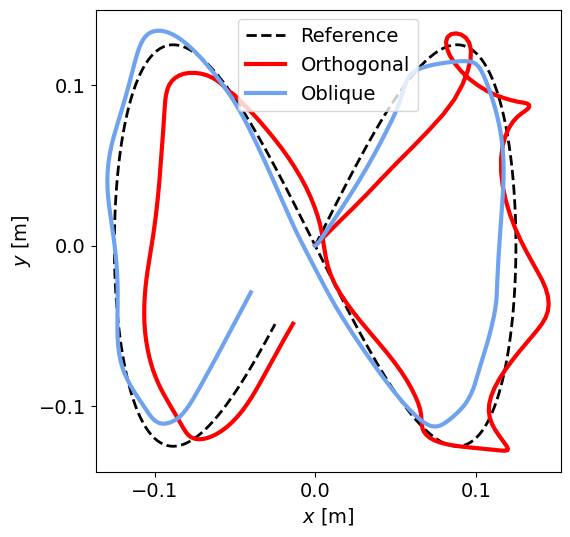

In [ ]:
# Plot the results
plot_trunk_results(z_ref, z_true_orth, z_true_opt, gusto_config_opt.N)

In [ ]:
import pandas as pd
df = pd.read_csv('../data.csv')

range_t = range(200, 500)

model = ssmr_orth
z_offset = np.mean(aut_trajs_obs[:, 2, -1])

u = np.array([
    [
        df['ux1'].iloc[t], df['uy1'].iloc[t], df['ux2'].iloc[t], df['uy2'].iloc[t], df['ux3'].iloc[t], df['uy3'].iloc[t]
    ] for t in range_t
])

z_gt = np.array([
    [df['x30'].iloc[t], df['y30'].iloc[t], df['z30'].iloc[t]] for t in range_t
])

z0 = z_gt[:4,:].copy()

z0 = z0[::-1] #most recent first
z0[:,2] -= z_offset
z0 = z0.flatten()

x0 = model.encode(z0)

x_rollout = model.rollout(x0, u)
y_rollout = np.array([model.decode(x) for x in x_rollout])
z_rollout = y_rollout[:, :3].copy()
z_rollout[:, 2] += z_offset

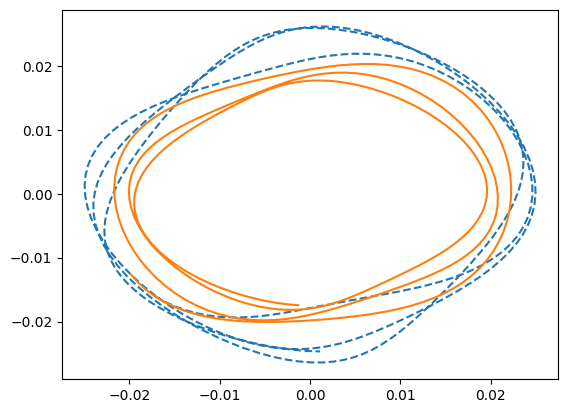

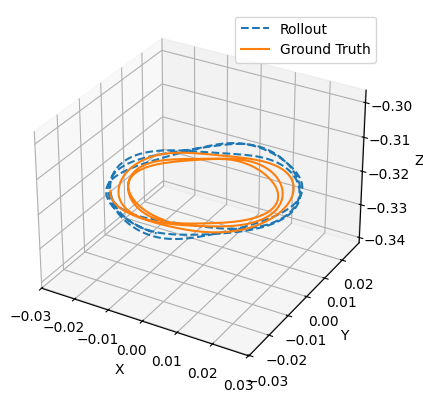

In [ ]:
import matplotlib.pyplot as plt

plt.plot(z_rollout[:, 0], z_rollout[:, 1], linestyle='--', label='Rollout')
plt.plot(z_gt[:, 0], z_gt[:, 1])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(z_rollout[:, 0], z_rollout[:, 1], z_rollout[:, 2], label='Rollout', linestyle='--')
ax.plot(z_gt[:, 0], z_gt[:, 1], z_gt[:, 2], label='Ground Truth')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
ax.legend()
plt.show()